<a href="https://colab.research.google.com/github/xinhe-zhang/heatwave/blob/main/HW2_%E5%BC%B5%E6%98%95%E8%8D%B7_R12228016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IPCS Heatwave HW2**
張昕荷 地理碩一 R12228016

***

Calculate the PR90 value, select the value excess PR90

Level 1: Choose the location from your HW1

Compare the total heatwave days between 1980-1990 and 2010-2020

Level 2: Follow Level 1

Compare the total heatwave intensity between 1980-1990 and 2010-2020

Level 3: Add the window of 15 days then repeat level 1 and 2



In [18]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from statistics import mean

!pip install cartopy
import cartopy.crs as ccrs

In [19]:
#Download ERA5 Tmax, 1979-2022, land only, 144*73
#I've changed the data to my own drive.
!gdown https://drive.google.com/uc?id=14okWeTrUH1nHZcgbmBZupRM6s5EcVoYu&export=download

Downloading...
From: https://drive.google.com/uc?id=14okWeTrUH1nHZcgbmBZupRM6s5EcVoYu
To: /content/ERA5_SFC_mx2t_1979-2022_r144x73_day.land.nc
100% 676M/676M [00:07<00:00, 85.8MB/s]


In [20]:
filename ='ERA5_SFC_mx2t_1979-2022_r144x73_day.land.nc'
ds_mx2t = xr.open_dataset(filename)

In [21]:
# Convert Kelvin to Celsius
ds_mx2t = ds_mx2t - 273.15

In [22]:
ds_mx2t['time'] = ds_mx2t['time'].astype('datetime64[ns]')
print(ds_mx2t['time'].dtype)
print(ds_mx2t['time'])

start_date = np.datetime64('1979-01-01')
end_date = np.datetime64('2023-01-01')  # Adjust the end date as needed

# Create a time array with intervals of 1 day
time_array = np.arange(start_date, end_date, np.timedelta64(1, 'D'))

print(time_array)
ds_mx2t['time'] = time_array #change time format to only date

datetime64[ns]
<xarray.DataArray 'time' (time: 16071)>
array(['1970-01-01T00:00:00.019790101', '1970-01-01T00:00:00.019790102',
       '1970-01-01T00:00:00.019790103', ..., '1970-01-01T00:00:00.020221229',
       '1970-01-01T00:00:00.020221230', '1970-01-01T00:00:00.020221231'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T00:00:00.019790101 ... 1970-01-...
Attributes:
    standard_name:  time
    long_name:      Date
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T
['1979-01-01' '1979-01-02' '1979-01-03' ... '2022-12-29' '2022-12-30'
 '2022-12-31']


In [23]:
#extract mx2t only
mx2t=ds_mx2t['mx2t'].copy()
# check the data size
print(mx2t.shape)

(16071, 73, 144)


In [24]:
data_365dy = mx2t.groupby('time.dayofyear').quantile(0.9) #select the 90th percentile
print(data_365dy.shape)#returns a tuple with each index having the number of corresponding elements

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


(366, 73, 144)


In [25]:
print(data_365dy) #a dataset of the 90th percentile temperature of each date throughout an year

<xarray.DataArray 'mx2t' (dayofyear: 366, lat: 73, lon: 144)>
array([[[-24.43181458, -24.43181458, -24.43181458, ..., -24.43181458,
         -24.43181458, -24.43181458],
        [-23.01976013, -23.1428894 , -23.21741791, ..., -22.77198639,
         -22.84514923, -22.93180084],
        [-22.33069458, -22.43992615, -22.46846466, ..., -21.76343384,
         -21.99133453, -22.19145203],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[-24.02689362, -24.02689362, -24.02689362, ..., -24.02689362,
         -24.02689362, -24.02689362],
        [-22.51490173, -22.57505035, -22.62718658, ..., -22.50256195,
         -22.48123627, -22.50967102],
        [-21.64683533, -21.90173035, -22.0548584 , ..., -21

In [26]:
# mask the data with
t2m_anom = mx2t.groupby('time.dayofyear') - data_365dy #calculate anomaly
print(t2m_anom.shape)
mask_90p = np.zeros_like(t2m_anom) #Return an array of zeros with the same shape and type as a given array.
mask_90p[np.where(t2m_anom>0)] = 1 #if anomaly > 0, give a value of 1 to the data
mx2t.values = mask_90p #replace mx2t value with 0 & 1

(16071, 73, 144)


I select Lytton(50N, 120W) as my location.

In [27]:
#select the data from 1980 to 1990
mx2t_1980_1990 = mx2t.sel(time=slice("1980-01-01", "1990-12-31"))
number_mx2t_1980_1990 = mx2t_1980_1990.sum("time")
number_mx2t_1980_1990

<xarray.DataArray 'mx2t' (lat: 73, lon: 144)>
array([[472., 472., 472., ..., 472., 472., 472.],
       [443., 438., 440., ..., 435., 437., 436.],
       [400., 393., 397., ..., 424., 411., 407.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0

In [28]:
#specify Lytton data
LT_number_mx2t_1980_1990=number_mx2t_1980_1990.sel(lat=67.5, lon=130, method="nearest")
LT_number_mx2t_1980_1990

<xarray.DataArray 'mx2t' ()>
array(379.)
Coordinates:
    lon      float64 130.0
    lat      float64 67.5

In [29]:
#select the data from 2010 to 2020
mx2t_2010_2020 = mx2t.sel(time=slice("2010-01-01", "2020-12-31"))
number_mx2t_2010_2020 = mx2t_2010_2020.sum("time")
number_mx2t_2010_2020

<xarray.DataArray 'mx2t' (lat: 73, lon: 144)>
array([[520., 520., 520., ..., 520., 520., 520.],
       [507., 511., 511., ..., 513., 519., 514.],
       [502., 519., 518., ..., 513., 516., 506.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0

In [30]:
LT_number_mx2t_2010_2020=number_mx2t_2010_2020.sel(lat=67.5, lon=130, method="nearest")
LT_number_mx2t_2010_2020

<xarray.DataArray 'mx2t' ()>
array(616.)
Coordinates:
    lon      float64 130.0
    lat      float64 67.5

In [31]:
#calculate the differece between 1980-1990 and 2010-2020
LT_diff = LT_number_mx2t_2010_2020 - LT_number_mx2t_1980_1990
print("The heatwave days between 1980-1990 and 2010-2020 in Lytton are : ", int(LT_diff), "days.")

The heatwave days between 1980-1990 and 2010-2020 in Lytton are :  237 days.


## **Level 2 : Calculate Heatwave Intensity**

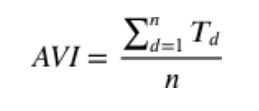

In [35]:
#extract mx2t only
hw_dt = ds_mx2t['mx2t'].copy()

In [53]:
LT_t2m_anom = t2m_anom.sel(lat=67.5, lon=130, method="nearest")

In [54]:
LT_hw_dt = hw_dt.sel(lat=67.5, lon=130, method="nearest")

In [62]:
LT_hw_dt = LT_hw_dt[np.where(LT_t2m_anom>0)]

In [68]:
LT_hw_dt_1980_1990 = LT_hw_dt.sel(time=slice("1980-01-01", "1990-12-31"))
print(LT_hw_dt_1980_1990)

<xarray.DataArray 'mx2t' (time: 379)>
array([-21.242096  , -16.392609  , -20.919464  , -23.9572    ,
       -26.27327   , -21.669754  , -14.290863  , -16.540985  ,
       -21.203796  ,  25.300995  ,  25.143768  ,  21.710114  ,
        22.616638  ,  26.12796   ,  24.433441  ,  21.162994  ,
        20.843018  ,  22.43155   ,  19.243011  ,  17.603058  ,
        17.831604  ,  18.311615  ,  17.966858  ,  17.048767  ,
        14.636139  ,  16.94513   ,  17.71048   ,  16.647064  ,
        16.956146  ,  14.717072  , -21.280472  , -19.987885  ,
       -17.583115  , -14.303009  , -13.09671   , -21.029022  ,
       -19.697906  , -19.881226  , -24.767303  , -23.520676  ,
       -24.987305  , -20.090073  , -15.089203  , -20.101227  ,
       -23.75502   , -21.771896  , -23.543     , -21.576813  ,
       -20.95015   , -10.624725  ,  -6.594757  ,  -9.855225  ,
        -4.4589233 ,  -2.6338196 ,  -5.7940063 ,  -0.80874634,
        -1.072998  ,   0.22515869,   1.1820984 ,  -0.63534546,
         6.243255

In [73]:
#calculate AVI for 1980-1990
LT_AVI_1980 = np.mean(LT_hw_dt_1980_1990)
LT_AVI_1980

<xarray.DataArray 'mx2t' ()>
array(-1.0378276, dtype=float32)
Coordinates:
    lon      float64 130.0
    lat      float64 67.5

In [70]:
LT_hw_dt_2010_2020 = LT_hw_dt.sel(time=slice("2010-01-01", "2020-12-31"))
print(LT_hw_dt_2010_2020)

<xarray.DataArray 'mx2t' (time: 616)>
array([-1.72777252e+01,  3.83209229e-01, -9.92462158e-01,  1.18597412e+00,
        4.86419678e+00,  5.78387451e+00,  6.39831543e+00,  7.20663452e+00,
        9.45886230e+00,  8.06298828e+00,  1.01846313e+01,  1.30013428e+01,
        9.52413940e+00,  8.46810913e+00,  8.34140015e+00,  1.56644287e+01,
        1.58294373e+01,  2.15690613e+01,  2.26947937e+01,  2.37869263e+01,
        2.55133972e+01,  2.57767029e+01,  2.73744812e+01,  2.70418396e+01,
        2.52975769e+01,  2.57588806e+01,  2.49709167e+01,  2.44977112e+01,
        2.57925415e+01,  2.71230164e+01,  1.66667786e+01,  1.93457642e+01,
        2.10452271e+01,  1.59273071e+01,  1.57673035e+01,  1.01965332e+00,
       -4.62356567e+00, -1.23843384e+01, -1.11025391e+01, -1.22167969e+01,
       -1.38542480e+01, -1.49369202e+01, -1.85895386e+01, -1.69789734e+01,
       -1.82592010e+01, -2.17822113e+01, -2.07861633e+01, -2.25458069e+01,
       -2.18639374e+01, -1.50627747e+01, -2.28558197e+01, -2.1

In [75]:
#calculate AVI for 2010-2020
LT_AVI_2010 = np.mean(LT_hw_dt_2010_2020)
LT_AVI_2010

<xarray.DataArray 'mx2t' ()>
array(0.52611357, dtype=float32)
Coordinates:
    lon      float64 130.0
    lat      float64 67.5

In [84]:
#calculate the differece between 1980-1990 and 2010-2020
LT_AVI_diff = LT_AVI_2010 - LT_AVI_1980
print("The heatwave intensity of Lytton in 2010-2020 is", round(float(LT_AVI_diff),2), "Celcius higher than that in 1980-1990.")

The heatwave intensity of Lytton in 2010-2020 is 1.56 Celcius higher than that in 1980-1990.
